# COSE474-2024F: Deep Learning HW2

## 0.1 Installation

In [ ]:
pip install d2l==1.0.3

## 7.1 From Fully Connected Layers to Convolutions

### 7.1.1 Invariance

The identification of an object does not depend on its location. This is called *spatial invariance*.

Intuitions:

1. In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image. This principle is called *translation invariance* (or *translation equivariance*).

2. The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. This is the *locality* principle. Eventually, these local representations can be aggregated to make predictions at the whole image level.

3. As we proceed, deeper layers should be able to capture longer-range features of the image, in a way similar to higher level vision in nature.

### 7.1.2 Constraining the MLP

The constraint is firstly introduced by mapping each hidden layer to the input by a one-to-one correspondence. Therefore, each hidde layer has the same number of weights as the number of inputs, which is still unfeasible in practice.

\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
   \sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}

#### 7.1.2.1 Translation Invariance

This principle implies that a shift in the input $\mathbf{X}$ should simply lead to a shift in the hidden representation $\mathbf{H}$, meaning the weights a bias does not actually depend on $(i,j)$.

\begin{aligned} \left[\mathbf{H}\right]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}


#### 7.1.2.2 Locality

This principle implore us to also include the surrounding pixels into the calculation of each hidden layer. Now each layer only has $4\Delta^2$ parameters where $\Delta$ is the window size for each parameter.

\begin{aligned} \left[\mathbf{H}\right]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}

### 7.1.4 Channels

To fit the 3 channels into the parameters, another coordinate $c$ is added
. An additional coordinate $d$ is added to represent the different feauture maps that can be learned for each hidden layer.

\begin{aligned} \left[\mathsf{H}\right]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}\end{aligned}

## 7.2 Convolutions for Images

### 7.2.1 The Cross-Correlation Operation

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.1 Convolutional Layers

The kernel layes are initialized rendomly, just as we would with a fully connected layer.

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3 Object Edge Detection in Images

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4 Learning a Kernel

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 7.826
epoch 4, loss 2.025
epoch 6, loss 0.632
epoch 8, loss 0.225
epoch 10, loss 0.087


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0183, -0.9588]])

### 7.2.5 Cross-Correlation and Convolution

Although the actual operation done here is cross-correlation and not convolution, the output in deep learning of both operations are identical, therefore cross-correlation operations will continue to be called convolution.

### 7.2.6 Feature Map and Receptive Field

Feature maps are the outputs of each hidden layer. Receptive field is all of the elements that affect the computation of an element $x$ during the forward propagation.

## 7.3 Padding and Stride

A way to control the shape of the feature maps.

In [ ]:
import torch
from torch import nn

### 7.3.1 Padding

Increasing the size or preserving the shape of the input.

In [ ]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2 Stride

Reducing the size drastically, usually in an unwieldy input case.

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4 Multiple Input and Multiple Output Channels

In [ ]:
import torch
from d2l import torch as d2l

### 7.4.1 Multiple Input Channels

In [ ]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.1 Multiple Output Channels

In [ ]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3 $1$$\times$ $1$ Convolutional Layer

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5 Pooling

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1 Maximum Pooling and Average Pooling

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2 Padding and Stride

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3 Multiple Channels

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6 Convolutional Neural Networks (LeNet)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.6.1 LeNet

In [ ]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2 Training

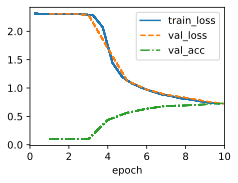

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 8.2 Networks Using Blocks (VGG)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1 VGG Blocks

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2 VGG Network

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3 Training

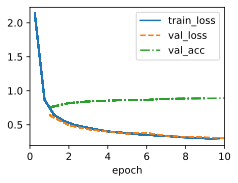

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## 8.6 Residual Networks (ResNet) and ResNeXt

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1 Function Classes

A larger function class does not guarantee we will get closer to the "truth" function $f^*$.
functionclasses.svg

Thus, only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network. ResNet applies this principle by making sure that every additional layer should more easily contain the identity function as one of its elements.

### 8.6.2 Residual Blocks

In [ ]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3 ResNet Model

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

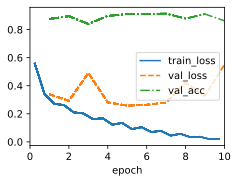

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Notes & Exercises

### 7.1 Notes

In this section, the structure of convolutional neural networks (CNNs) is derived from foundational principles related to image processing and computer vision. Key points include:

1. **Translation Invariance**: CNNs are designed to treat all patches of an image uniformly, reflecting the idea that similar features should be detected regardless of their position in the image.

2. **Locality**: CNNs utilize small neighborhoods of pixels to compute hidden representations, allowing the model to focus on local patterns and features while significantly reducing the number of parameters needed.

3. **Parameter Reduction**: By restricting the convolutional kernel through locality and translation invariance, CNNs achieve a dramatic reduction in complexity. This makes previously computationally infeasible problems tractable while maintaining the model's expressive power.

4. **Incorporating Channels**: The addition of channels (beyond RGB) reintroduces some complexity lost from the aforementioned restrictions.

### 7.2 Exercises

In [ ]:
# Creating an image X with diagonal edges
X_diagonal = torch.ones((6, 8))

X_diagonal[torch.arange(6), torch.arange(6)] = 0       # Main diagonal
X_diagonal[torch.arange(6), torch.arange(1, 7)] = 0   # Upper diagonal

X_diagonal

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1.]])

In [ ]:
corr2d(X_diagonal, K)

tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]])

The kernel still detects the diagonal edges

In [ ]:
corr2d(X_diagonal.t(), K)

tensor([[-1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  0.,  0.],
        [ 0.,  1.,  0., -1.,  0.],
        [ 0.,  0.,  1.,  0., -1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.]])

In [ ]:
corr2d(X_diagonal, K.t())

tensor([[-1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  1.,  0.]])

Transposing any parameters does not result in any meaningful changes.

### 7.4 Notes

* Channels in CNNs combine the benefits of both MLPs (enabling significant
nonlinearities) and convolutions (enabling localized analysis of features).
* They allow CNNs to analyze multiple features, like edges and shapes, simultaneously, making the model more expressive and versatile for computer vision tasks.
* Channels also offer a balance between the reduced number of parameters (due to translation invariance and locality) and the need for complex and diverse models.
* **Computational Cost**: The flexibility provided by channels has a high computational cost. For a single convolution, the cost scales with the size of the image, the kernel, and the number of input and output channels.

### 7.5 Exercise

Average pooling through convolution

In [ ]:
import torch.nn.functional as F

def avg_pooling_via_convolution(X, pool_size, stride=1):
    # Create the average pooling kernel
    kernel_size = pool_size
    kernel_value = 1.0 / (kernel_size[0] * kernel_size[1])
    kernel = torch.full((1, 1, *kernel_size), kernel_value)

    # Apply the convolution with the average pooling kernel
    X = X.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    Y = F.conv2d(X, kernel, stride=stride)

    return Y.squeeze()

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
assert torch.equal(pool2d(X, (2, 2), 'avg'), avg_pooling_via_convolution(X, (2, 2)))

### 7.6 Exercises

Modernizing LeNet
1. Replace average pooling with max-pooling
2. Replace the softmax layer with ReLU.

In [ ]:
class Modern_LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

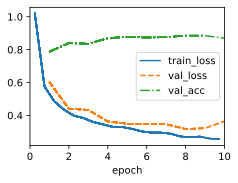

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = Modern_LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

Definitely an improvement by simply changing the activation function and pooling method.

### 8.2 Exercises

Constructing the VGG-16 model

In [ ]:
VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


Constructing the VGG-19 model

In [ ]:
VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.6 Notes

ResNet Key Features:

1. **Residual Connections**: Skip connections allow inputs to bypass layers, helping gradients flow and making it easier to train very deep networks.

2. **Deep Architectur**e: ResNet can be extremely deep (e.g., 50+ layers), improving the model's ability to learn complex patterns.

3. **Batch Normalization**: Normalizes layer inputs to stabilize training and accelerate convergence.

4. **Modular Design**: Built from repeating residual blocks, simplifying architecture and scaling.